In [1]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Lambda, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv')

In [3]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Data preprocessing - shuffling the training dataframe takes ~7 minutes
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [5]:
cols = list(train_df.columns)
cols.remove('label')

x = train_df[cols]
y = train_df['label']

# Splitting the dataset into training and validation(dev) sets
x_train, x_dev, y_train, y_dev = train_test_split(x, y, test_size=0.1, random_state=0)

In [6]:
# Testing dataset (this is the set on which we'll do predictions and then submit it)
x_test = test_df[cols]

In [7]:
print(f'Training set size: {len(x_train)}')
print(f'Validation set size: {len(x_dev)}')

Training set size: 37800
Validation set size: 4200


In [8]:
print(x_train.shape)
print(x_train.values.reshape(-1, 28, 28).shape)

(37800, 784)
(37800, 28, 28)


In [9]:
# Reshaping the datasets to feed images of 28X28 pixels to our neural network
# And also scaling the images
x_train = x_train.values.reshape(-1, 28, 28) / 255
x_dev   = x_dev.values.reshape(-1, 28, 28) / 255
x_test  = x_test.values.reshape(-1, 28, 28) / 255

In [10]:
print(x_train.shape)
print(np.expand_dims(x_train, axis=-1).shape)

(37800, 28, 28)
(37800, 28, 28, 1)


In [11]:
# Adding an additional dimension of channel (1 as images are grayscale)
x_train = np.expand_dims(x_train, axis=-1)
x_dev   = np.expand_dims(x_dev, axis=-1)
x_test  = np.expand_dims(x_test, axis=-1)

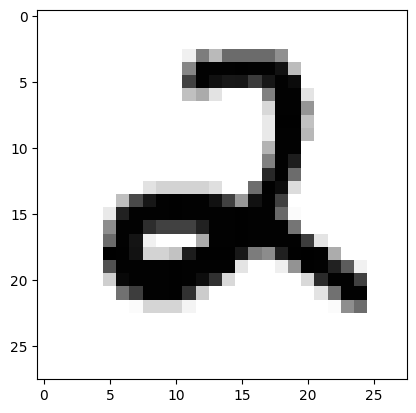

In [12]:
plt.imshow(x_train[0].reshape((28, 28)), cmap=plt.cm.binary)

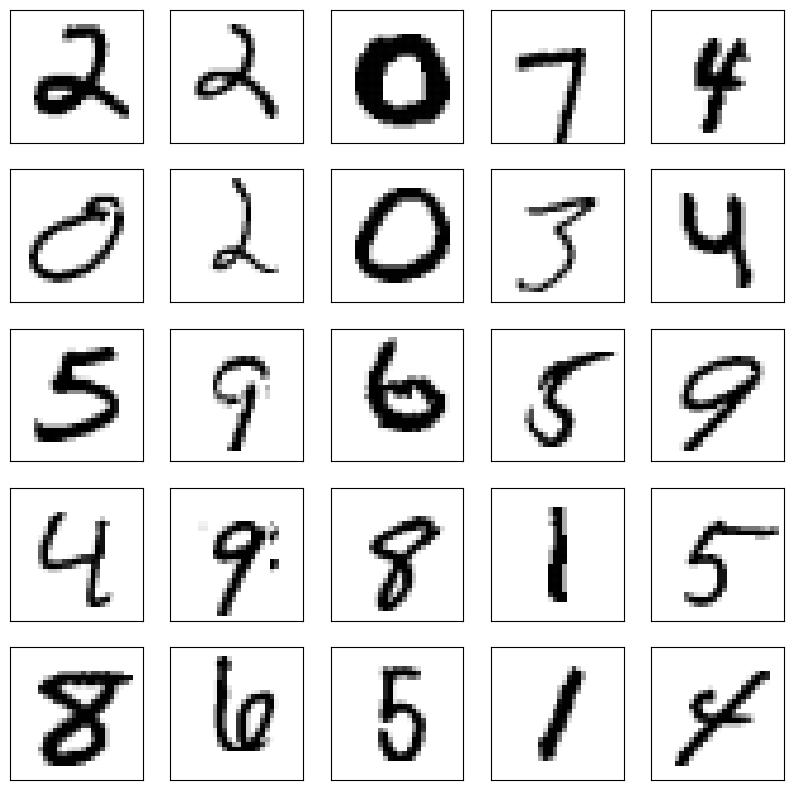

In [13]:
# Looking at first 25 training examples

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    
    # reshaping the images as (28, 28, 1) is an invalid shape to plot imgs
    plt.imshow(x_train[i].reshape((28, 28)), cmap=plt.cm.binary)
    
plt.show()

In [14]:
def data_augmentation(x_data, y_data, batch_size):
    datagen = ImageDataGenerator(
        featurewise_center=False,            # set input mean to 0 over the dataset
        samplewise_center=False,             # set each sample mean to 0
        featurewise_std_normalization=False, # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,                 # apply ZCA whitening
        rotation_range=10,                   # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                    # Randomly zoom image 
        width_shift_range=0.1,               # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,              # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,               # randomly flip images
        vertical_flip=False,                 # randomly flip images
    )
    
    
    datagen.fit(x_data)
    train_data = datagen.flow(x_data, y_data, batch_size=batch_size, shuffle=True)
    
    return train_data

In [15]:
BATCH_SIZE = 64
aug_train_data = data_augmentation(x_train, y_train, BATCH_SIZE)

In [16]:
#Modelling
def build_model():
    # Neural Network Architecture
    layers = [
        Conv2D(filters=96, kernel_size=(11, 11), strides=2, activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu'),
        Flatten(),
        Dense(9216, activation='relu'),
        Dense(4096, activation='relu'),
        Dense(4096, activation='relu'),
        Dense(10, activation='softmax')
    ]

    model = Sequential(layers)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


model = build_model()
model.summary()

C:\Users\starg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 9, 9, 96)            │          11,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 4, 4, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 4, 4, 256)           │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 9216)                │      37,757,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      37,752,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │          40,970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,959,434 (354.61 MB)

 Trainable params: 92,959,434 (354.61 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
callbacks = [
    ReduceLROnPlateau(monitor="loss",factor=0.1, patience=2, min_lr=0.000001, verbose=1),
]

In [18]:
#takes 9 minutes
history = model.fit(
    aug_train_data, 
    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
    batch_size=BATCH_SIZE,
    validation_data=(x_dev, y_dev), 
    epochs=1,
    callbacks=callbacks
)

C:\Users\starg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


590/590 ━━━━━━━━━━━━━━━━━━━━ 526s 888ms/step - accuracy: 0.7387 - loss: 0.7865 - val_accuracy: 0.9540 - val_loss: 0.1460 - learning_rate: 1.0000e-04


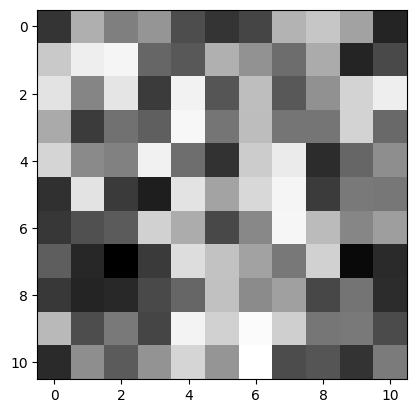

In [19]:
#Visualizing CNN - Plotting the 96th filter of the 1st conv layer
top_layer = model.layers[0]
plt.imshow(top_layer.get_weights()[0][:, :, :, 95].squeeze(), cmap='gray')

In [20]:
print(f'Shape of 1st conv layer weights: {model.layers[0].get_weights()[0].shape}')
print(f'Shape of 2nd conv layer weights: {model.layers[2].get_weights()[0].shape}')

Shape of 1st conv layer weights: (11, 11, 1, 96)
Shape of 2nd conv layer weights: (5, 5, 96, 256)


In [21]:
def plot_filters_for_conv_layer(model, layer_index, num_columns=5, cmap='binary', how_many='all'):
    layer = model.layers[layer_index]
    filter_weights = layer.get_weights()[0]
    
    num_filters = layer.filters if how_many == 'all' else how_many
    num_rows = (num_filters // num_columns) + (num_filters % num_columns)
    
    f, axs = plt.subplots(num_rows, num_columns, figsize=(20, 5 * num_rows))
    row_count = 0  # to plot num_columns figs in an individual row
    
    if not isinstance(axs, np.ndarray):
        # When num_cloumns == how_many
        axs = np.array(axs)  # to make axs iterable
        
    for idx, row_ax in enumerate(axs):
        # plotting filters in a row
        for i, ax in enumerate(row_ax):
            if row_count + i >= num_filters:
                break
                
            if len(filter_weights.shape) == 4:
                if filter_weights.shape[2] == 1:
                    ax.imshow(filter_weights[:, :, :, row_count + i].squeeze(), cmap=cmap)
                else:
                    ax.imshow(filter_weights[:, :, 0, row_count + i].squeeze(), cmap=cmap)
            else:
                break
                            
        # increasing row_count by num_columns
        row_count += num_columns 

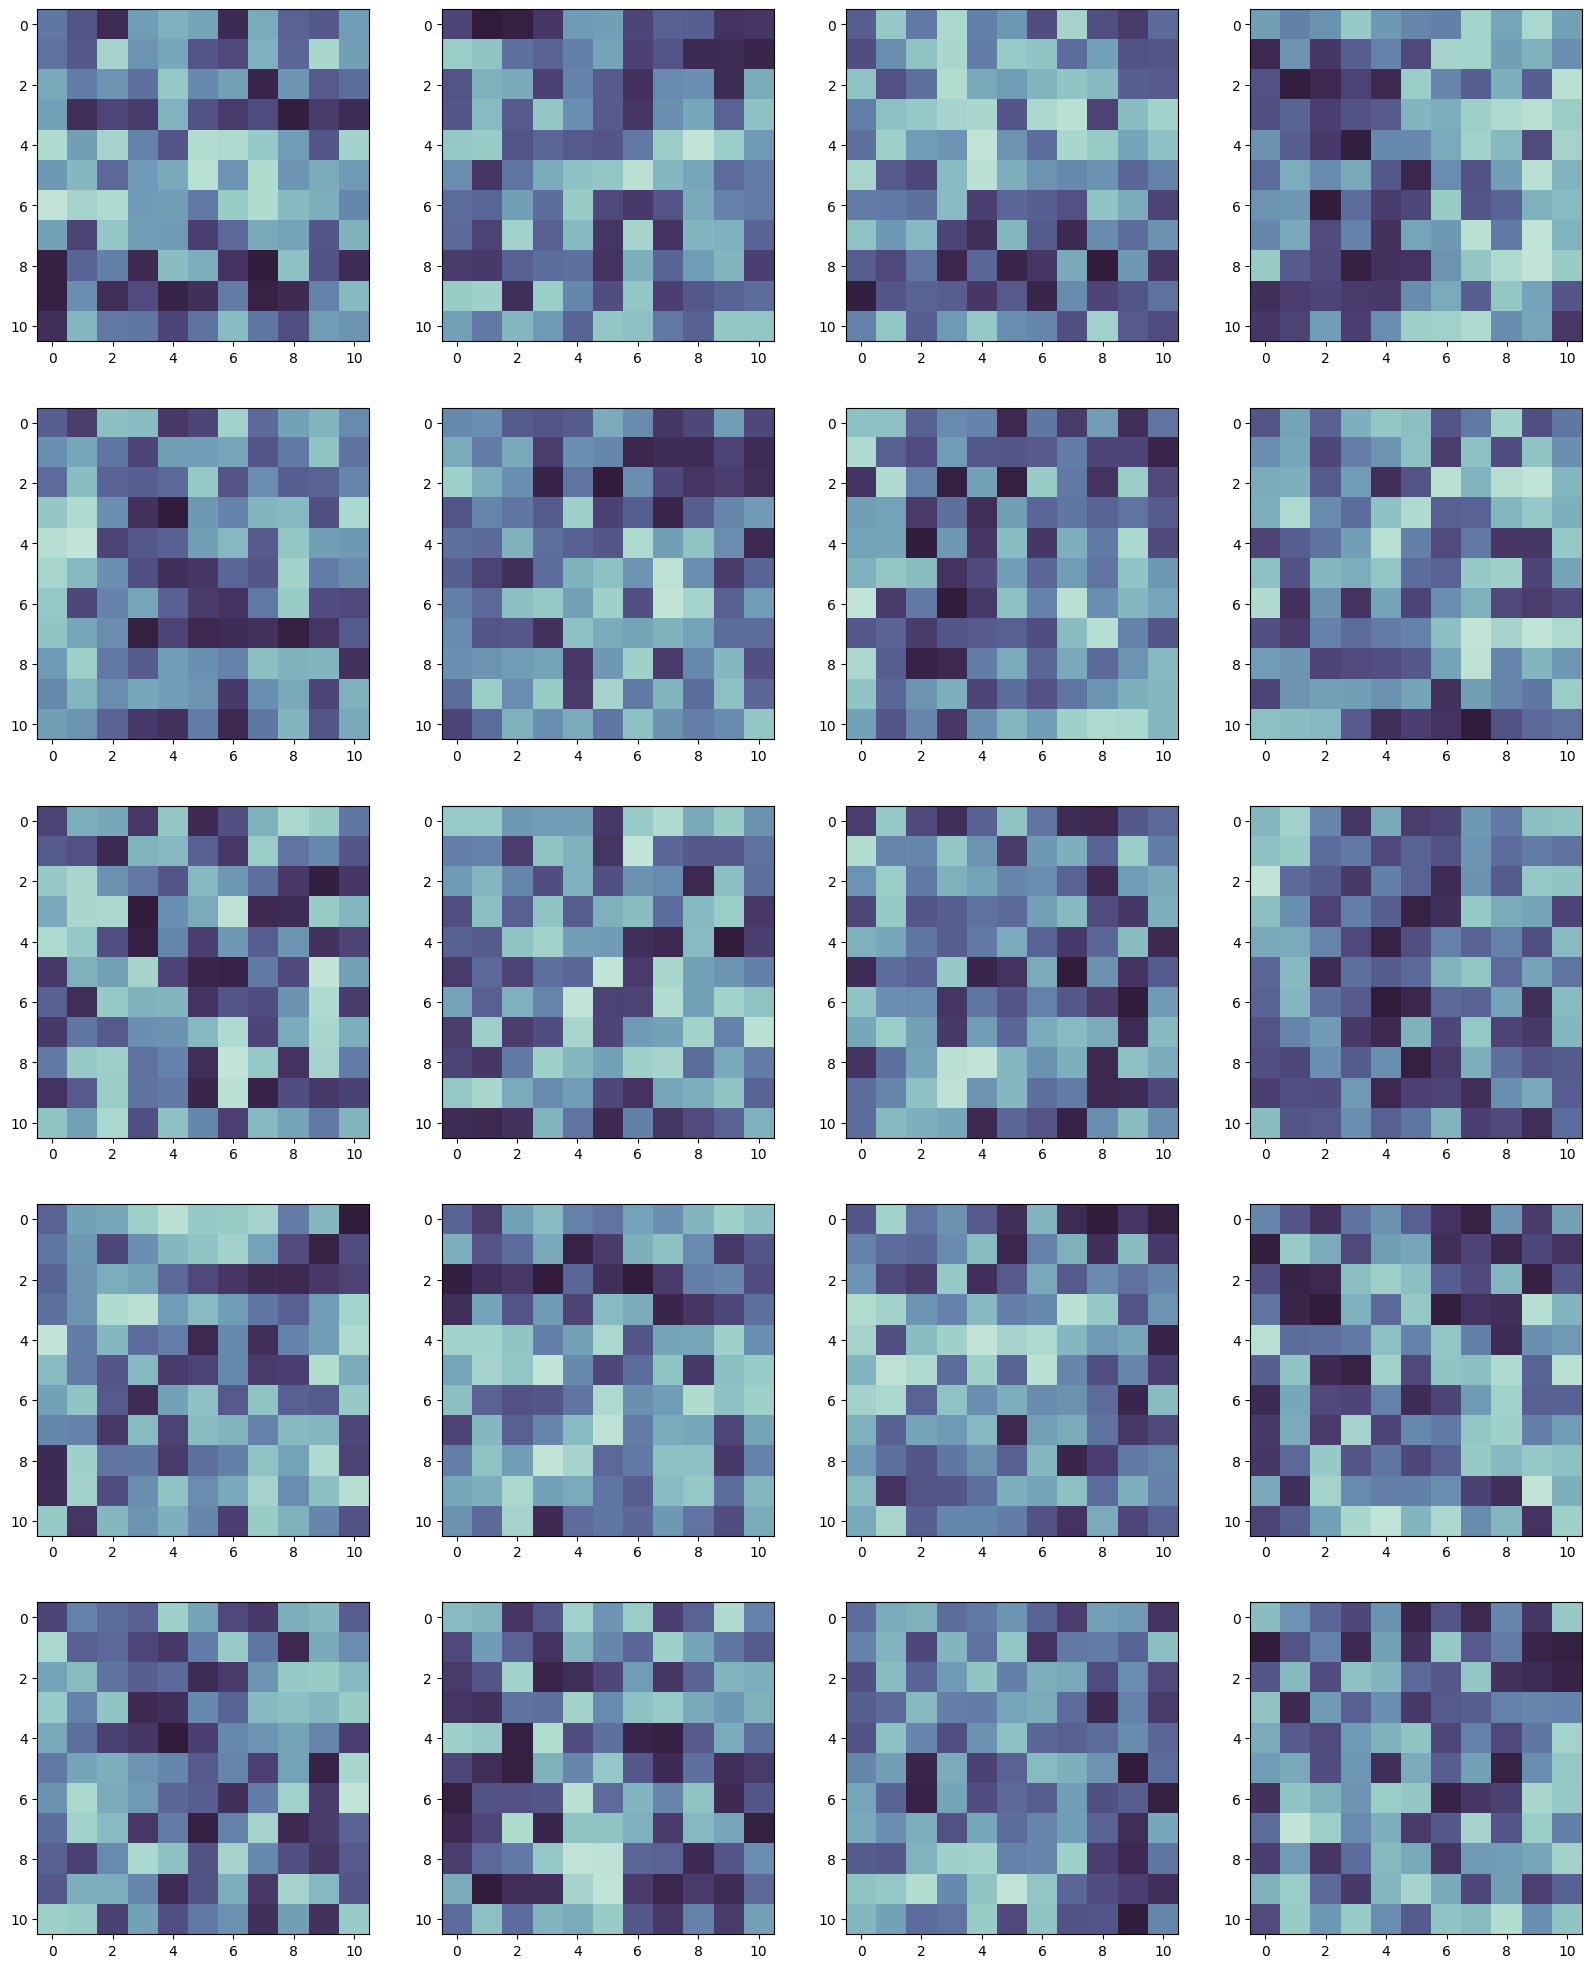

In [22]:
plot_filters_for_conv_layer(
    model, 
    0, 
    num_columns=4,
    cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True), 
    how_many=20
)  
# 11X11 filters

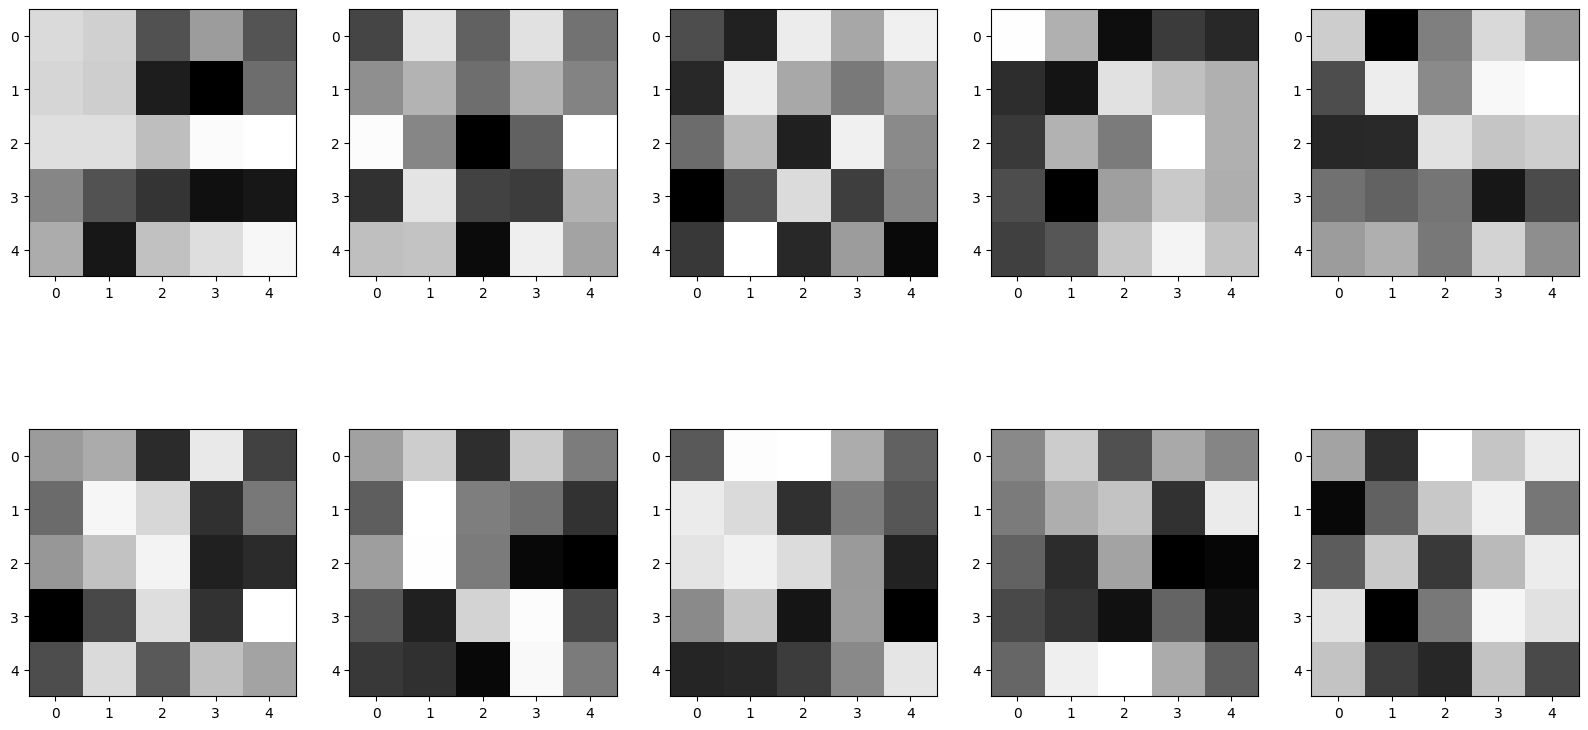

In [23]:
plot_filters_for_conv_layer(
    model, 
    2, 
    num_columns=5,
    how_many=10
)  
# 5X5 filters

In [24]:
[idx for idx in range(len(model.layers)) if 'conv' in model.layers[idx].name]

[0, 2]

In [25]:
#Visualizing feature maps
def plot_feature_maps_for_single_conv_layer(model, layer_id, input_img, num_columns=10, cmap='binary'):
    ref_model = Model(inputs=model.inputs, outputs=model.layers[layer_id].output)
    feature_map = ref_model.predict(input_img)
    
    num_filters = feature_map[0].shape[2]
    num_rows = (num_filters // num_columns) + (num_filters % num_columns)

    fig = plt.figure(figsize=(16, 2 * num_rows))
    ix = 1
    for _ in range(num_rows):
        for _ in range(num_columns):
            if ix == num_filters:
                break
        
            # specify subplot and turn of axis
            ax = plt.subplot(num_rows, num_columns, ix)
            ax.set_xticks([])
            ax.set_yticks([])
        
            # plot filter channel in grayscale
            plt.imshow(feature_map[0, :, :, ix-1], cmap=cmap)
            ix += 1
            
    # show the figure
    plt.show()

In [26]:
visualize_feature_maps_for = 7

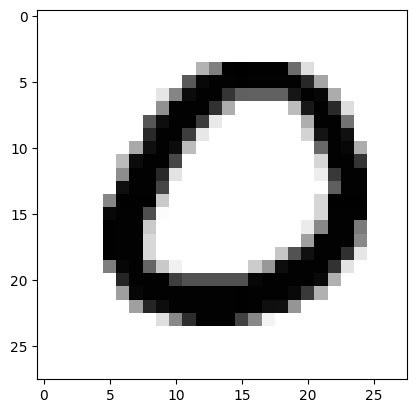

In [27]:
plt.imshow(x_train[visualize_feature_maps_for].reshape((28, 28)), cmap=plt.cm.binary)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


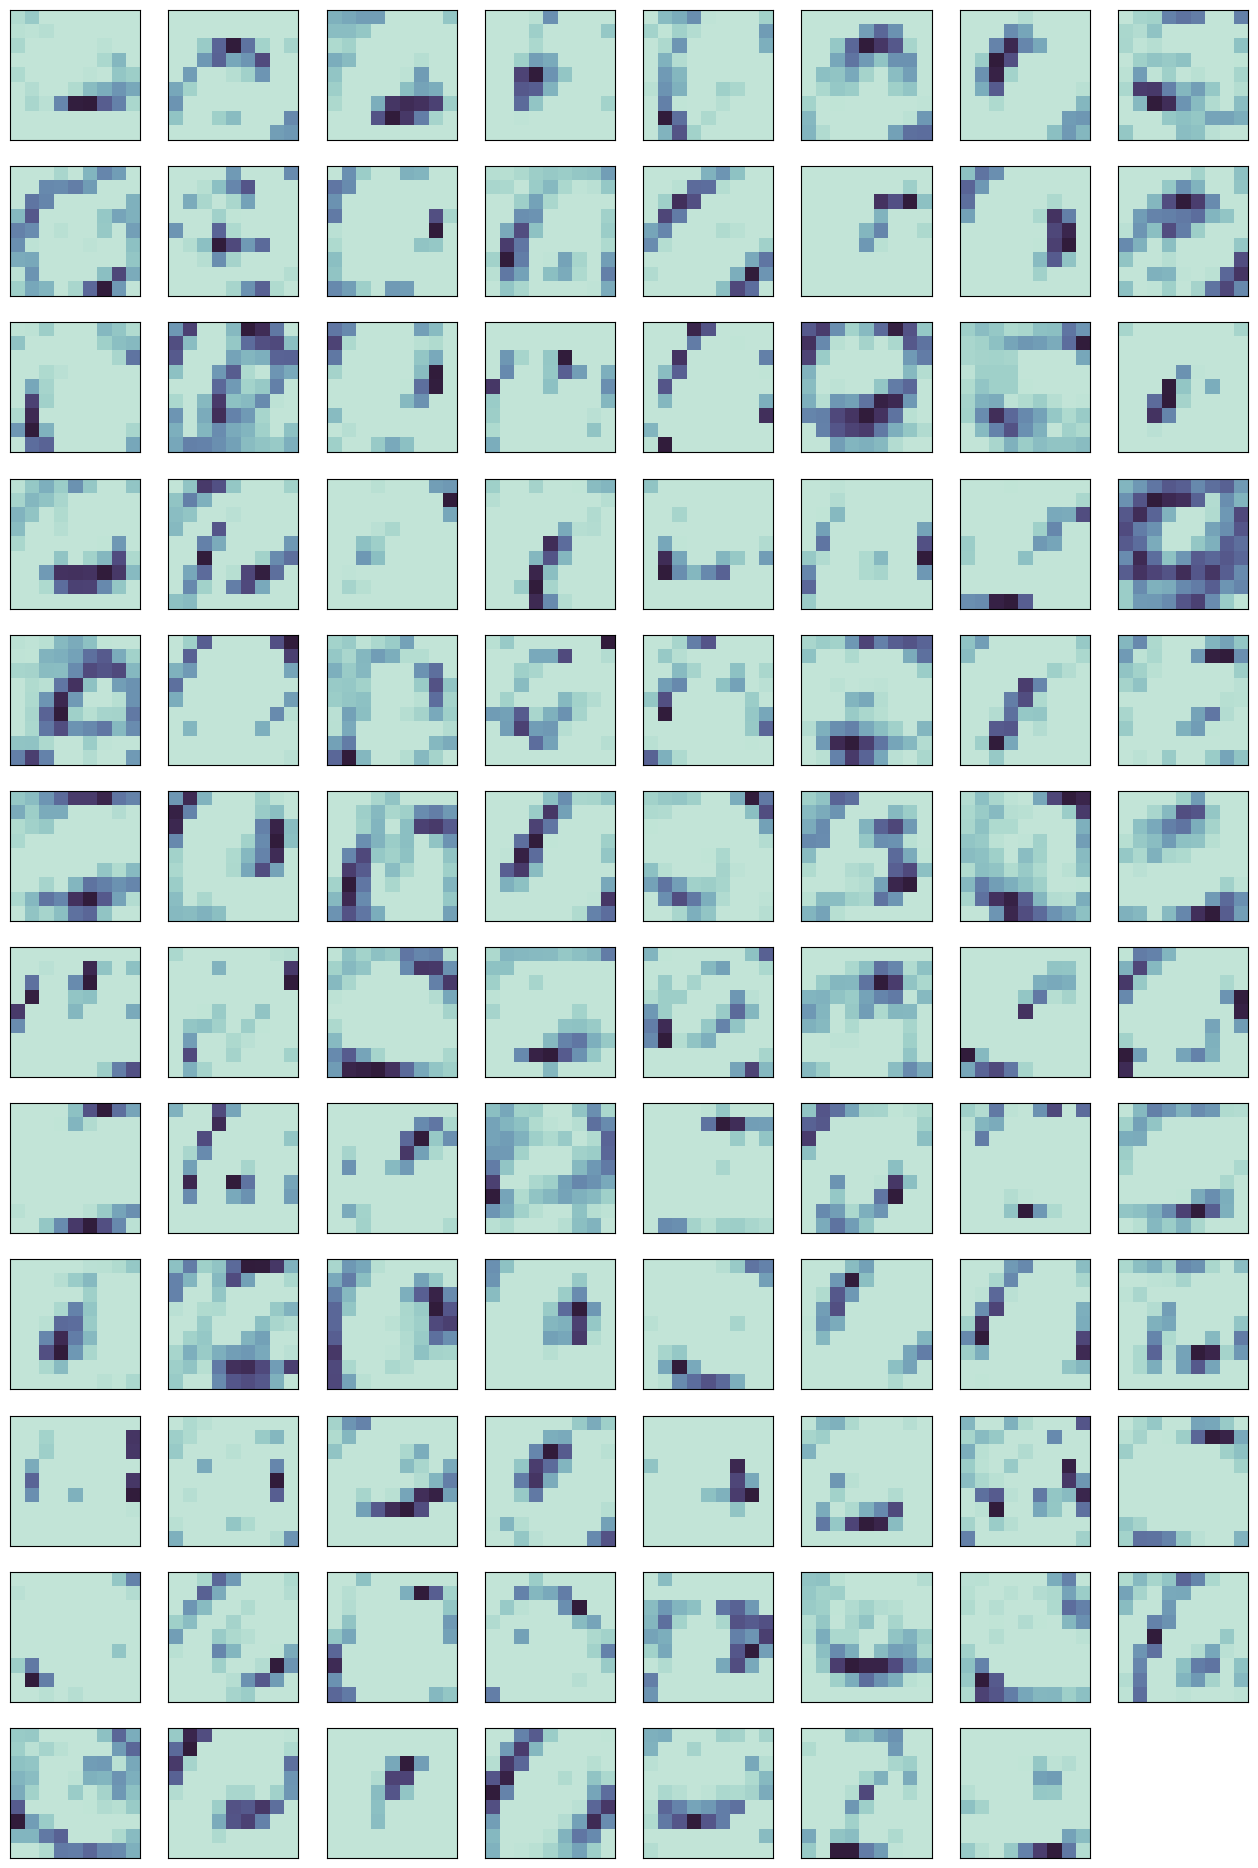

In [28]:
plot_feature_maps_for_single_conv_layer(
    model, 
    0, 
    x_train[visualize_feature_maps_for][np.newaxis, ...], 
    num_columns=8,
    cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


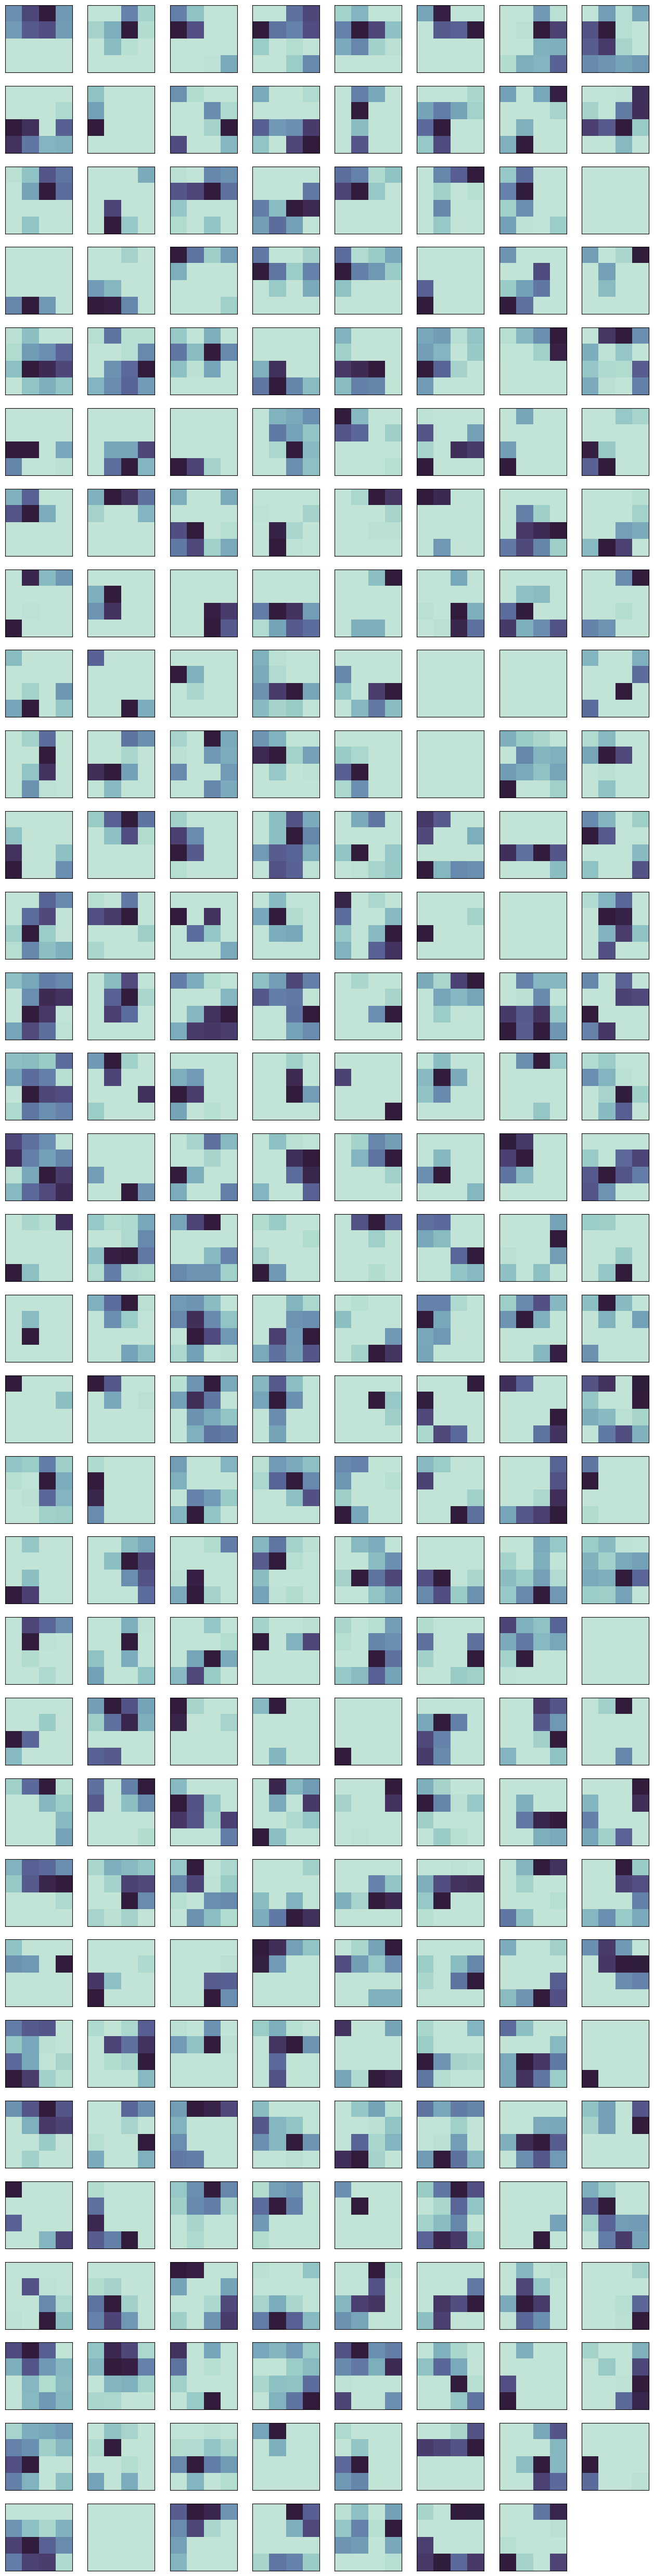

In [29]:
plot_feature_maps_for_single_conv_layer(
    model, 
    2, 
    x_train[visualize_feature_maps_for][np.newaxis, ...],
    num_columns=8,
    cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
)

In [30]:
#Here model is evaluated on the validation dataset. 
#plot_confusion_matrix function prints and plots the confusion matrix. Normalization can be applied by setting normalize=True.
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    plt.figure(figsize=(8, 8))
    
    plt.imshow(cm, interpolation='nearest', cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step


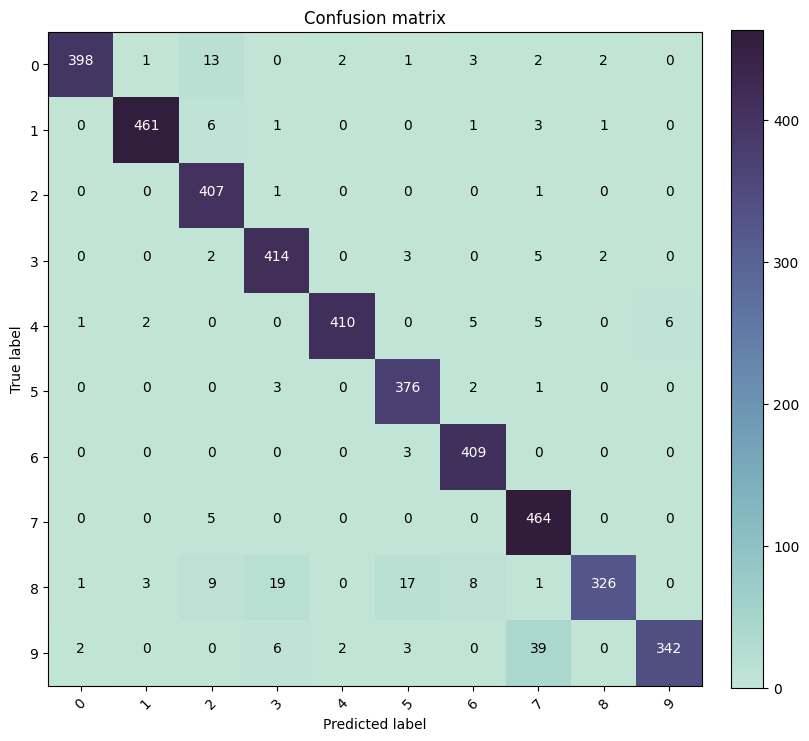

In [31]:
# Predict labels for validation dataset
y_pred = model.predict(x_dev)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_dev, y_pred_classes) 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(10)) 

[1.4522489e-07 2.4068950e-05 9.6944468e-06 9.9957985e-01 2.7309335e-08
 3.4366717e-04 4.6738236e-09 3.8871167e-05 6.3689851e-07 3.1082445e-06]
Predicted digit is: 3
Accuracy is: 99.957985%


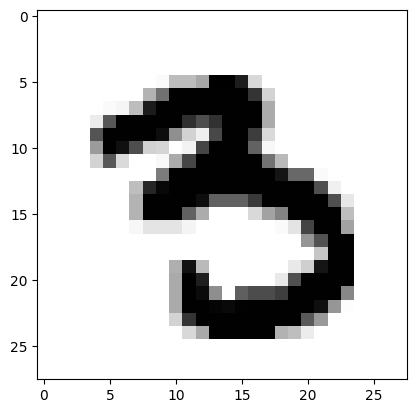

In [32]:
# Verify the results
predictions = y_pred

print(predictions[0]) # Confidence matrix

print('Predicted digit is: ' + str(np.argmax(predictions[0])))
print('Accuracy is: ' + str(np.max(predictions[0] * 100)) + '%')

# Actual Digit
plt.imshow(x_dev[0].reshape((28, 28)), cmap=plt.cm.binary)

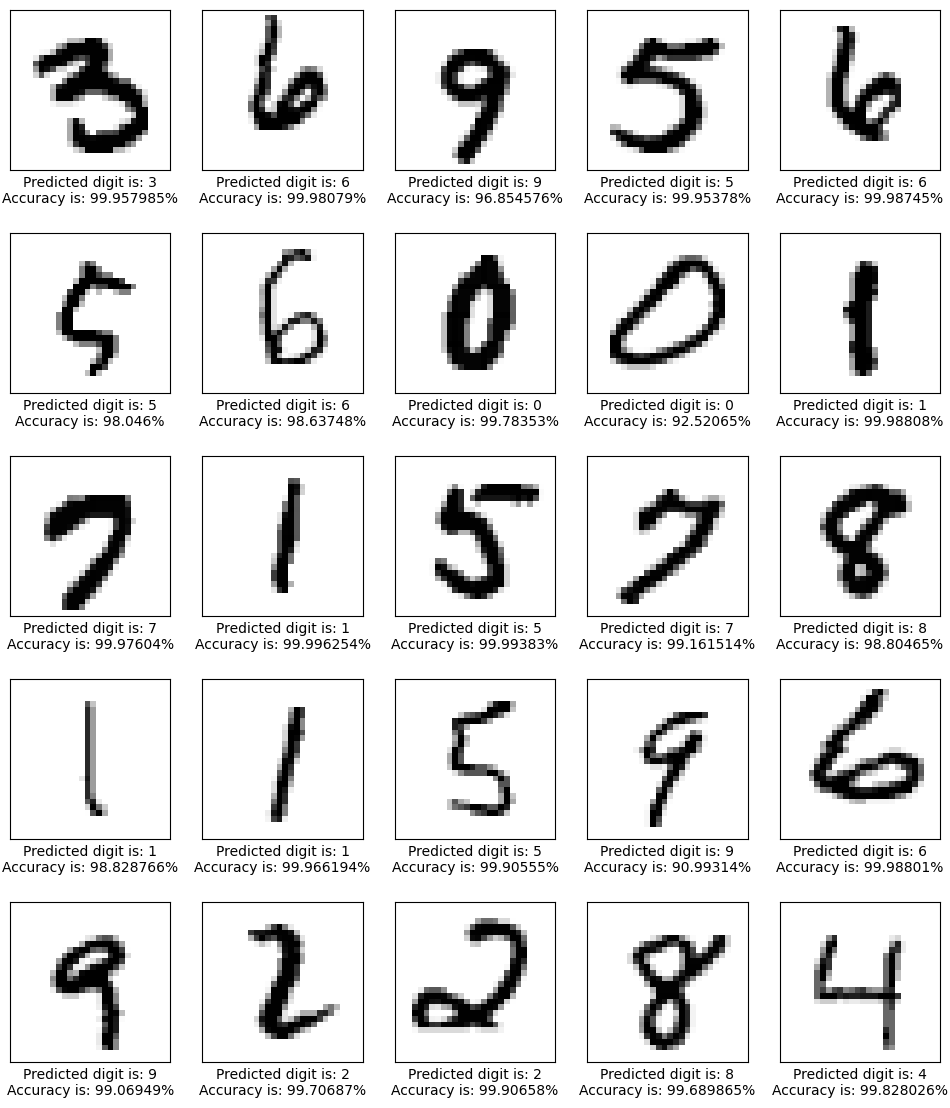

In [33]:
# Seeing first 25 validation images predictions
plt.figure(figsize=(12, 14))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_dev[i].reshape((28, 28)), cmap=plt.cm.binary)
    
    plt.xlabel(
        'Predicted digit is: ' + str(np.argmax(predictions[i])) + 
        '\n' + 
        'Accuracy is: ' + str(np.max(predictions[i] * 100)) + '%'
    )